# Assignment 2
The objective of this assignment is to get you familiarizewith  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

In [1]:
# Installing Libraries
!pip install scikit-learn matplotlib Pillow

In [2]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import numpy.linalg as LA
import pandas as pd
from scipy import linalg

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from collections import defaultdict

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score,precision_recall_fscore_support,confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.manifold import Isomap
plt.ion()
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [3]:
opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

### Load Dataset

In [4]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [5]:
# Loading the dataset
# eg.
# dirpath = './dataset/IMFDB/'
Yale_data,Yale_labels = load_data('./dataset/Yale_face_database')
Yale_N,Yale_H,Yale_W = Yale_data.shape[0:3]
Yale_C = 1 if opt['is_grayscale'] else Yale_data.shape[3]
#########################################################################
IIITCFW_data,IIITCFW_labels = load_data('./dataset/IIIT-CFW')
IIITCFW_N,IIITCFW_H,IIITCFW_W = IIITCFW_data.shape[0:3]
IIITCFW_C = 1 if opt['is_grayscale'] else IIITCFW_data.shape[3]
######################################################################
IMFDB_data,IMFDB_labels = load_data('./dataset/IMFDB')
IMFDB_N,IMFDB_H,IMFDB_W = IMFDB_data.shape[0:3]
IMFDB_C = 1 if opt['is_grayscale'] else IMFDB_data.shape[3]

Dataset shape: (165, 32, 32, 3)
Dataset shape: (672, 32, 32, 3)
Dataset shape: (400, 32, 32, 3)


Yale Images


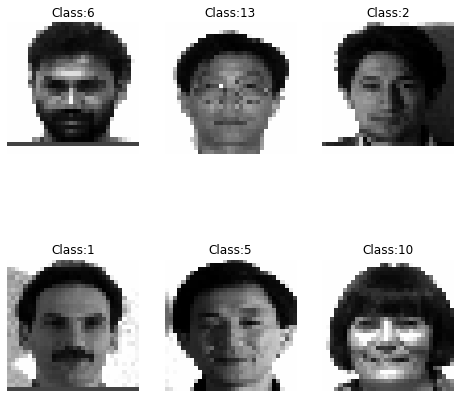

IIITCFW Images


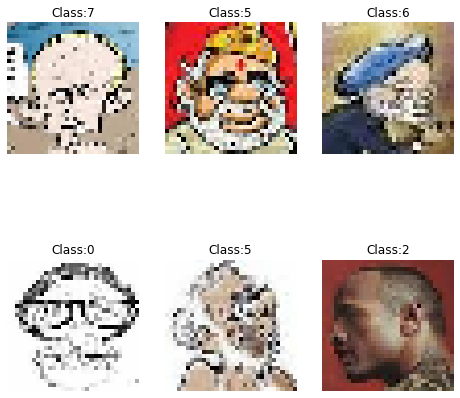

IMFDB Images


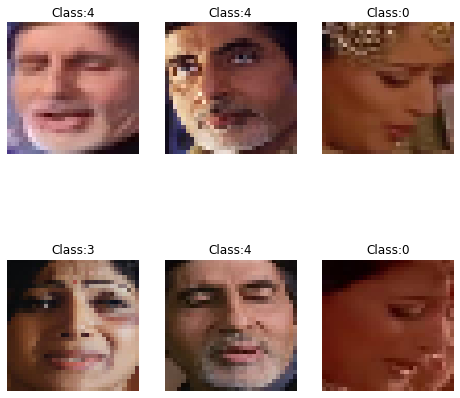

In [6]:
# Show Yale Images
print("Yale Images")
ind = np.random.randint(0,Yale_labels.shape[0],6)
disply_images(Yale_data[ind,...],Yale_labels[ind], row=2,col=3)

# Show IIITCFW Images
print("IIITCFW Images")
ind = np.random.randint(0,IIITCFW_labels.shape[0],6)
disply_images(IIITCFW_data[ind,...],IIITCFW_labels[ind], row=2,col=3)

# Show IMFDB Images
print("IMFDB Images")
ind = np.random.randint(0,IMFDB_labels.shape[0],6)
disply_images(IMFDB_data[ind,...],IMFDB_labels[ind], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [7]:
# Flatten to apply PCA/LDA
Yale_data_flat = Yale_data.reshape((Yale_N,Yale_H*Yale_W*Yale_C))

IIITCFW_data_flat = IIITCFW_data.reshape((IIITCFW_N,IIITCFW_H*IIITCFW_W*IIITCFW_C))

IMFDB_data_flat = IMFDB_data.reshape((IMFDB_N,IMFDB_H*IMFDB_W*IMFDB_C))

###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [8]:
def get_pca(X,k):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components=k)
    X_k = pca.fit_transform(X)
    return X_k,pca

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [9]:
def get_kernel_pca(X, k,kernel='rbf', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree)
    X_k = kpca.fit_transform(X)
    return X_k,kpca

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [10]:
def get_lda(X,y, k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    lda = LDA(n_components=k)
    X_k = lda.fit_transform(X,y)
    return X_k,lda

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [11]:
def get_kernel_lda(X,y,k,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k)
    X_k = klda.fit_transform(X,y)
    return X_k,klda

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [12]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [13]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features

# Questions

1(a). What are eigen faces? 

___________________________

Eigenfaces refer to the eigenvectors of the covariance matrix of the  dataset of images.These are used to create a new feature space representation of images which is then used for face recognition or general pattern recognition.


1(b).  How many eigen vec-tors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples andmake a convincing argument.

The number of eigenvectors required to  “satisfactorily” reconstruct a person are:
- Number of eigenvectors to cover variance in Yale data are  61
- Number of eigenvectors to cover variance in IIITCFW data are  308
- Number of eigenvectors to cover variance in IMFDB data are  123 
#### Here we use the fact that to reconstruct we atleast use eigenvectors that captute 95 % of the variance of the data
We can also see from eigenspectrum(if we set appropriate axes scale) that approximately 50,240,100 eigenvectors are sufficient for a good reconstruction.
We can say so by observing the points in eigenspectrum at which it tends to zero.

In [14]:
# Compute your features 
# eg.
# X_3D = get_kernel_lda(X,y,3)
Yale_3D,_ = get_pca(Yale_data_flat,3)

IIITCFW_3D,_ = get_pca(IIITCFW_data_flat,3)

IMFDB_3D,_ = get_pca(IMFDB_data_flat,3)


In [15]:
def eigenspec(X,datatype):
    covmat = np.cov(X.T)
    eigvals = LA.eigvals(covmat)
    plt.plot(eigvals)
    plt.title(datatype)
    plt.show()
def numberofvects(X):
    threshold = .95
    covmat = np.cov(X.T)
    eigvals = LA.eigvals(covmat)
    s = np.sum(eigvals)
    ct = 0
    for i in range(len(eigvals)):
        ct += eigvals[i]
        if(ct/s>=threshold):
            break
    number = i
    return number
def scatter_plot3D(X,y,datatype):
    fig = plt.figure(figsize = (10,8))
    ax = fig.add_subplot(111,projection='3d')
    ax.scatter(X[:,0],X[:,1],X[:,2],c=y)
    plt.title(datatype)
    plt.show()
def scatter_plot2D(X,y,datatype):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(111)
    ax.scatter(X[:,0],X[:,1],c=y)
    plt.title(datatype)
    plt.show()

Scatter Plot for Yale data


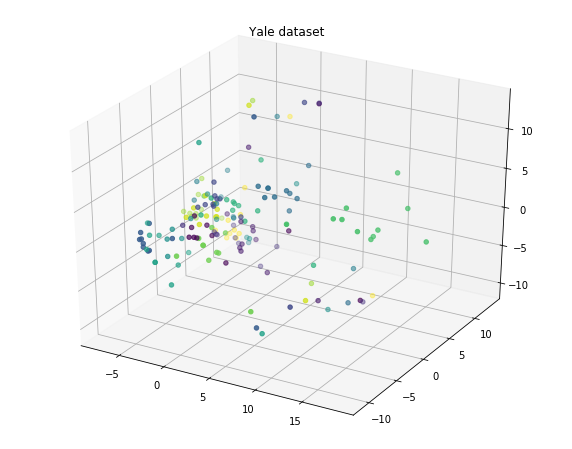

Scatter Plot for IIITCFW data


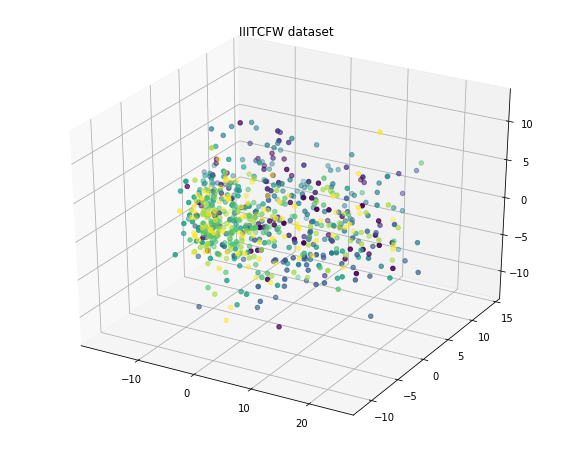

Scatter Plot for IMFDB data


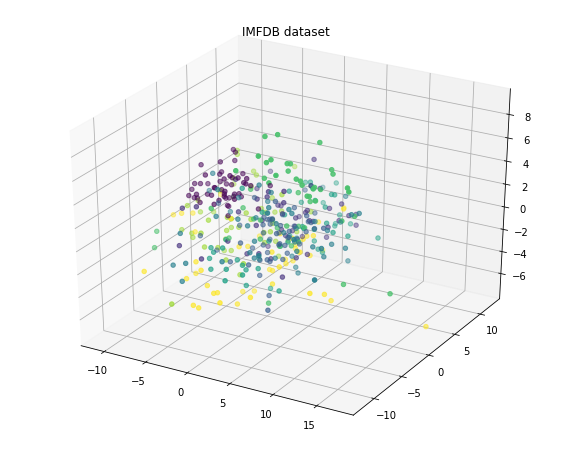

In [16]:
# Create a scatter plot  
# eg.
# fig = plt.figure(figsize=(8,8))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X_3D[:,0],X_3D[:,1],X_3D[:,2],c=y)
print("Scatter Plot for Yale data")
scatter_plot3D(Yale_3D,Yale_labels,"Yale dataset")
print("Scatter Plot for IIITCFW data")
scatter_plot3D(IIITCFW_3D,IIITCFW_labels,"IIITCFW dataset")
print("Scatter Plot for IMFDB data")
scatter_plot3D(IMFDB_3D,IMFDB_labels,"IMFDB dataset")

Eigen Spectrum for Yale dataset


/home/nsk06/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


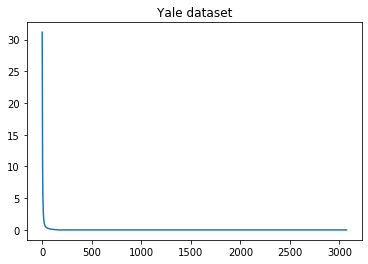

Eigen Spectrum for IIITCFW dataset


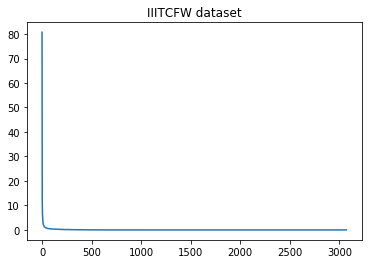

Eigen Spectrum for IMFDB dataset


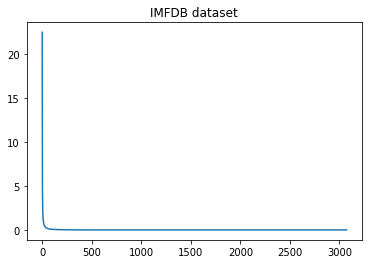

In [17]:
# Plot the eigen value spectrum 
print("Eigen Spectrum for Yale dataset")
eigenspec(Yale_data_flat,"Yale dataset")
print("Eigen Spectrum for IIITCFW dataset")
eigenspec(IIITCFW_data_flat,"IIITCFW dataset")
print("Eigen Spectrum for IMFDB dataset")
eigenspec(IMFDB_data_flat,"IMFDB dataset")

In [18]:
Yale_vects = numberofvects(Yale_data_flat)
IIITCFW_vects = numberofvects(IIITCFW_data_flat)
IMFDB_vects = numberofvects(IMFDB_data_flat)
print("Number of eigenvectors to cover variance in Yale data are ",Yale_vects)
print("Number of eigenvectors to cover variance in IIITCFW data are ",IIITCFW_vects)
print("Number of eigenvectors to cover variance in IMFDB data are ",IMFDB_vects)

Number of eigenvectors to cover variance in Yale data are  61
Number of eigenvectors to cover variance in IIITCFW data are  308
Number of eigenvectors to cover variance in IMFDB data are  123


1(c). Reconstruct  the  image  back for each case


In [19]:
def reconstruct_images(transformed_data,components):
    """
        Reconstruct the images back by just using the selected principal components. 


        You have to write the code in this code block.
        You can change the functions provided above (eg, get_pca, get_lda) for your use case. 
            
        @params: 
                Input parameters

        @return reconstructed_X => reconstructed image
        
    """
    
    reconstruct_X = components.inverse_transform(transformed_data)
    
    return reconstruct_X
def reconstructionplots(numcomps,data):
    errors = []
    for i in range(3,numcomps):
        x,comps = get_pca(data,i)
        reconstruct = comps.inverse_transform(x)
        errors.append(np.sqrt(np.mean((data - reconstruct)**2)))
    points = [i for i in range(3,numcomps)]
    ax.plot(points,errors)
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Yale Reconstructed Images using 60 eigenvectors


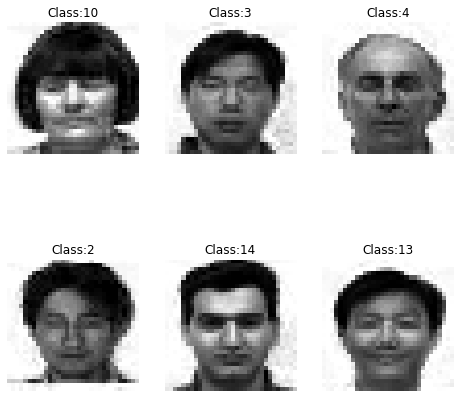

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IIITCFW  Reconstructed Images  using 300 eigenvectors


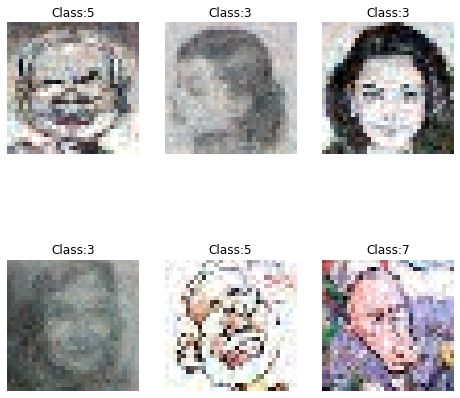

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IMFDB Reconstructed Images  using 120 eigenvectors


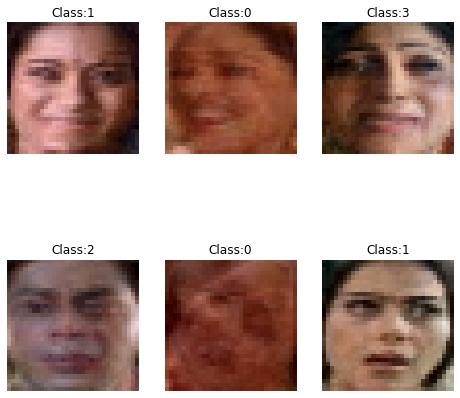

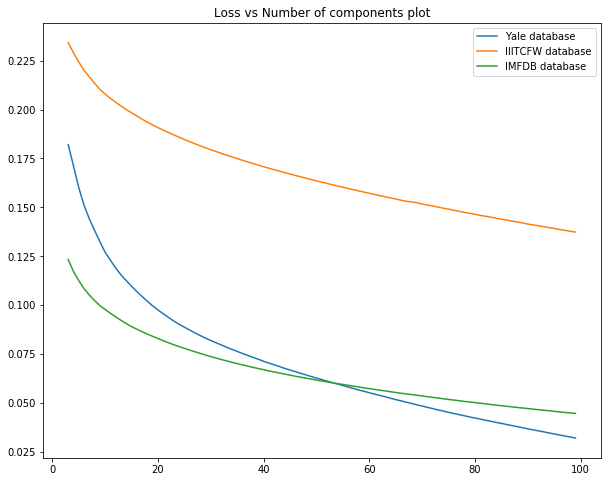

In [20]:
# Display results 
# X_reconstruced = reconstruct_images()

# Display random images
# ind = np.random.randint(0,y.shape[0],6)
# disply_images(X_reconstruced_3D[ind,...],y[ind],row=2,col=3)
x,comp = get_pca(Yale_data_flat,60)
Yale_reconstruct = reconstruct_images(x,comp)
Yale_reconstruct = Yale_reconstruct.reshape((Yale_N,Yale_H,Yale_W,Yale_C))

x,comp = get_pca(IIITCFW_data_flat,300)
IIITCFW_reconstruct = reconstruct_images(x,comp)
IIITCFW_reconstruct = IIITCFW_reconstruct.reshape((IIITCFW_N,IIITCFW_H,IIITCFW_W,IIITCFW_C))

x,comp = get_pca(IMFDB_data_flat,120)
IMFDB_reconstruct = reconstruct_images(x,comp)
IMFDB_reconstruct = IMFDB_reconstruct.reshape((IMFDB_N,IMFDB_H,IMFDB_W,IMFDB_C))
# Show Yale Images
print("Yale Reconstructed Images using 60 eigenvectors")
ind = np.random.randint(0,Yale_labels.shape[0],6)
disply_images(Yale_reconstruct[ind,...],Yale_labels[ind], row=2,col=3)

# Show IIITCFW Images
print("IIITCFW  Reconstructed Images  using 300 eigenvectors")
ind = np.random.randint(0,IIITCFW_labels.shape[0],6)
disply_images(IIITCFW_reconstruct[ind,...],IIITCFW_labels[ind], row=2,col=3)

# Show IMFDB Images
print("IMFDB Reconstructed Images  using 120 eigenvectors")
ind = np.random.randint(0,IMFDB_labels.shape[0],6)
disply_images(IMFDB_reconstruct[ind,...],IMFDB_labels[ind], row=2,col=3)

# Show the reconstruction error
numcomps = 100
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
reconstructionplots(numcomps,Yale_data_flat)
# ax.legend("Yale database")
reconstructionplots(numcomps,IIITCFW_data_flat)
# ax.legend("IIITCFW database")
reconstructionplots(numcomps,IMFDB_data_flat)
ax.legend(("Yale database","IIITCFW database","IMFDB database"))
plt.title("Loss vs Number of components plot")
plt.show()

##### From the above graph we notice that reconstruction error is maximum for IIIT-CFW followed by IMFDB and Yale-Face Database.Hence from the above graph we can conclude that IIIT-CFW is the most difficult to reconstruct with fewer eigen-values. This is  because  the  database  has  a  higher  spread  in  theeigenvalue spectrum, so, to account for more of thetotal spread,  we need to take more eigenvalues

1(d). Which person/identity is difficult to represent com-pactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers

In [21]:
# code goes here
def maxerror(data,labels,numcomps):
    uniq = len(list(set(labels)))
    errors = [0]*uniq
    transform,comp = get_pca(data,numcomps)
    rec = comp.inverse_transform(transform)
    for i in range(len(data)):
        errors[labels[i]] = np.sqrt(np.mean((data[i] - rec[i])**2))
    return errors.index(max(errors))

In [22]:
numcomps = 10
print("Yale dataset class : ",maxerror(Yale_data_flat,Yale_labels,numcomps))
print("IIITCFW dataset class : ",maxerror(IIITCFW_data_flat,IIITCFW_labels,numcomps))
print("IMFDB dataset class : ",maxerror(IMFDB_data_flat,IMFDB_labels,numcomps))

Yale dataset class :  10
IIITCFW dataset class :  4
IMFDB dataset class :  3


2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 

2(b)Which method works well? Do a comparitivestudy. 


You already know the paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [23]:
# Define your classifier here. You can use libraries like sklearn to create your classifier 

class Classifier():
    def __init__(self,classifiertype,kernel,iters,degree=3,hidden_layer_sizes = (4000,)):
        if(classifiertype=="SVM"):
            self.classifier = SVC(C = 1,max_iter = iters,kernel = kernel,degree = degree)
        elif(classifiertype=="Logistic Regression"):
            self.classifier = LogisticRegression(random_state = 0,solver = 'lbfgs',multi_class = 'multinomial')
        elif(classifiertype=="MLP"):
            self.classifier = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes)
    
    
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def classify(self,X):
        """
            Given an input X classify it into appropriate class. 
        """
        prediction = self.classifier.predict(X)
        return prediction
        
    def confusion_matrix(self,pred,y):
        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """
        confmat = confusion_matrix(y,pred)
        return confmat
        
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.classifier.fit(X_train,y_train)
        
    def validate(self,X_validate,y_validate):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        preds = self.classifier.predict(X_validate)
        
        
        # Create a confusion matrix
        confmat = confusion_matrix(y_validate,preds)
        # Calculate Validation accuracy 
        accuracy = accuracy_score(y_validate,preds)
        # Calculate precision and recall 
        precision,recall,fscore,support = precision_recall_fscore_support(y_validate,preds,average="micro")
        # Calculate F1-score
    
        return confmat,accuracy,precision,recall,fscore,support

In [24]:
# Create a train and validation split to train your classifier 
Yale_train,Yale_test,Yale_train_labels,Yale_test_labels = train_test_split(Yale_data_flat,Yale_labels,test_size = 0.1)
IIITCFW_train,IIITCFW_test,IIITCFW_train_labels,IIITCFW_test_labels = train_test_split(IIITCFW_data_flat,IIITCFW_labels,test_size = 0.1)
IMFDB_train,IMFDB_test,IMFDB_train_labels,IMFDB_test_labels = train_test_split(IMFDB_data_flat,IMFDB_labels,test_size = 0.1)


In [25]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, classification error, accuracy, f1-score

# Print the table. (You can use Pandas)
from IPython.display import display, HTML
from pandas.plotting import table 
def maketable(traindata,trainlabels,testdata,testlabels,feature,classifiertype,datatype):
    if feature == "VGG":
        if(datatype == "Yale"):
            path = "./dataset/Yale_face_database/"
            VGGfeatures = get_vgg_features(path)
            traindata,testdata,trainlabels,testlabels = train_test_split(VGGfeatures,Yale_labels,test_size=0.1)
        elif(datatype == "IIITCFW"):
            path = "./dataset/IIIT-CFW/"
            VGGfeatures = get_vgg_features(path)
            traindata,testdata,trainlabels,testlabels = train_test_split(VGGfeatures,IIITCFW_labels,test_size=0.1)
        elif(datatype == "IMFDB"):
            path = "./dataset/IMFDB/"
            VGGfeatures = get_vgg_features(path)
            traindata,testdata,trainlabels,testlabels = train_test_split(VGGfeatures,IMFDB_labels,test_size=0.1)
    elif feature == "Resnet":
        if(datatype == "Yale"):
            path = "./dataset/Yale_face_database/"
            Resfeatures = get_resnet_features(path)
            traindata,testdata,trainlabels,testlabels = train_test_split(Resfeatures,Yale_labels,test_size=0.1)
        elif(datatype == "IIITCFW"):
            path = "./dataset/IIIT-CFW/"
            Resfeatures = get_resnet_features(path)
            traindata,testdata,trainlabels,testlabels = train_test_split(Resfeatures,IIITCFW_labels,test_size=0.1)
        elif(datatype == "IMFDB"):
            path = "./dataset/IMFDB/"
            Resfeatures = get_resnet_features(path)
            traindata,testdata,trainlabels,testlabels = train_test_split(Resfeatures,IMFDB_labels,test_size=0.1)
    elif feature == "PCA":
        traindata,comps = get_pca(traindata,75)
        testdata = comps.transform(testdata)
    elif feature == "KPCA":
        traindata,comps = get_kernel_pca(traindata,75)
        testdata = comps.transform(testdata)
    elif feature == "LDA":
        traindata,comps = get_lda(traindata,trainlabels,100)
        testdata = comps.transform(testdata)
    elif feature == "KLDA":
        traindata,comps = get_kernel_lda(traindata,trainlabels,100)
        testdata = comps.transform(testdata)
    
    if classifiertype == "SVM":
        classifier = Classifier(classifiertype,"linear",1000,3)
    elif classifiertype == "Logistic Regression":
        classifier = Classifier(classifiertype,"linear",1000,3)
    elif classifiertype == "MLP":
        classifier = Classifier(classifiertype,"linear",1000,3,hidden_layer_sizes = (50,10))
    
#     print("here",traindata.shape,trainlabels.shape)
    classifier.train(traindata,trainlabels)
    confmat,accuracy,precision,recall,fscore,support = classifier.validate(testdata,testlabels)
    reduced = traindata.shape[1]
    out =  [confmat,accuracy,precision,recall,fscore,support,reduced]
    return out

def createtable(traindata,testdata,trainlabels,testlabels,datatype):
    print(datatype)
#     print("check",traindata.shape,trainlabels.shape)
    store_accuracy = []
    store_confmat = []
    classifiers = ["MLP","SVM","Logistic Regression",]
    features = ["PCA","KPCA","LDA","KLDA","VGG","Resnet"]
    dic = {"Feature Used":[],"Reduced Dimension Space":[],"Classification Error":[],"Accuracy":[],"F1-Score":[]}
    for i in features:
        for j in classifiers:
            out = maketable(traindata,trainlabels,testdata,testlabels,i,j,datatype)
            store_accuracy.append(out[1])
            store_confmat.append(out[0])
            dic["Feature Used"].append( j + " classifier " + "with " + i + " feature")
            dic["Reduced Dimension Space"].append(out[6])
            dic["Classification Error"].append(1-out[1])
            dic["Accuracy"].append(out[1])
            dic["F1-Score"].append(out[4])
    dic = pd.DataFrame(dic)
#     dic = dic.sort_values(by=['Accuracy'],ascending=False)
    display(dic)
    print()  
    return store_accuracy,store_confmat

In [26]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
Yale_accs,Yale_confmats = createtable(Yale_train,Yale_test,Yale_train_labels,Yale_test_labels,"Yale")
IIITCFW_accs,IIITCFW_confmats = createtable(IIITCFW_train,IIITCFW_test,IIITCFW_train_labels,IIITCFW_test_labels,"IIITCFW")
IMFDB_accs,IMFDB_confmats = createtable(IMFDB_train,IMFDB_test,IMFDB_train_labels,IMFDB_test_labels,"IMFDB")

Yale


,Feature Used,Reduced Dimension Space,Classification Error,Accuracy,F1-Score
0,MLP classifier with PCA feature,75,0.235294,0.764706,0.764706
1,SVM classifier with PCA feature,75,0.058824,0.941176,0.941176
2,Logistic Regression classifier with PCA feature,75,0.058824,0.941176,0.941176
3,MLP classifier with KPCA feature,75,0.588235,0.411765,0.411765
4,SVM classifier with KPCA feature,75,0.941176,0.058824,0.058824
5,Logistic Regression classifier with KPCA feature,75,0.588235,0.411765,0.411765
6,MLP classifier with LDA feature,14,0.000000,1.000000,1.000000
7,SVM classifier with LDA feature,14,0.000000,1.000000,1.000000
8,Logistic Regression classifier with LDA feature,14,0.000000,1.000000,1.000000
9,MLP classifier with KLDA feature,14,0.058824,0.941176,0.941176



IIITCFW


,Feature Used,Reduced Dimension Space,Classification Error,Accuracy,F1-Score
0,MLP classifier with PCA feature,75,0.352941,0.647059,0.647059
1,SVM classifier with PCA feature,75,0.455882,0.544118,0.544118
2,Logistic Regression classifier with PCA feature,75,0.294118,0.705882,0.705882
3,MLP classifier with KPCA feature,75,0.485294,0.514706,0.514706
4,SVM classifier with KPCA feature,75,0.529412,0.470588,0.470588
5,Logistic Regression classifier with KPCA feature,75,0.485294,0.514706,0.514706
6,MLP classifier with LDA feature,7,0.647059,0.352941,0.352941
7,SVM classifier with LDA feature,7,0.617647,0.382353,0.382353
8,Logistic Regression classifier with LDA feature,7,0.617647,0.382353,0.382353
9,MLP classifier with KLDA feature,7,0.617647,0.382353,0.382353



IMFDB


,Feature Used,Reduced Dimension Space,Classification Error,Accuracy,F1-Score
0,MLP classifier with PCA feature,75,0.250,0.750,0.750
1,SVM classifier with PCA feature,75,0.275,0.725,0.725
2,Logistic Regression classifier with PCA feature,75,0.250,0.750,0.750
3,MLP classifier with KPCA feature,75,0.375,0.625,0.625
4,SVM classifier with KPCA feature,75,0.700,0.300,0.300
5,Logistic Regression classifier with KPCA feature,75,0.325,0.675,0.675
6,MLP classifier with LDA feature,7,0.325,0.675,0.675
7,SVM classifier with LDA feature,7,0.350,0.650,0.650
8,Logistic Regression classifier with LDA feature,7,0.350,0.650,0.650
9,MLP classifier with KLDA feature,7,0.300,0.700,0.700


Yale Dataset
AxesImage(43.2,25.92;223.2x223.2)


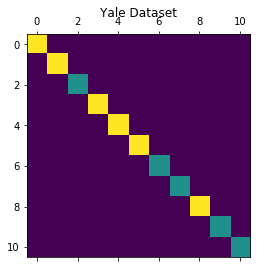

IIITCFW Dataset
AxesImage(43.2,25.92;223.2x223.2)


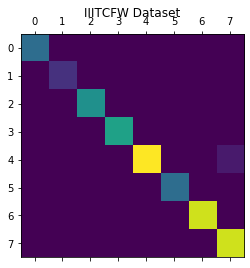

IMFDB Dataset
AxesImage(43.2,25.92;223.2x223.2)


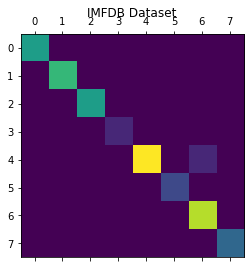

In [27]:
# For each dataset print the confusion matrix for the best model 
print("Yale Dataset")
print(plt.matshow(Yale_confmats[Yale_accs.index(max(Yale_accs))]))
plt.title("Yale Dataset")
plt.show()
print("IIITCFW Dataset")
print(plt.matshow(IIITCFW_confmats[IIITCFW_accs.index(max(IIITCFW_accs))]))
plt.title("IIITCFW Dataset")
plt.show()
print("IMFDB Dataset")
print(plt.matshow(IMFDB_confmats[IMFDB_accs.index(max(IMFDB_accs))]))
plt.title("IMFDB Dataset")
plt.show()

3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for thiscourse/exams.

In [28]:
# Compute TSNE for different features and create a scatter plot
def Tsne_plots(X,y,datatype):
    k = 3 # Number of components in TSNE

    # Compute
    X_TSNE3 = TSNE(n_components=k).fit_transform(X)
    X_TSNE2 = TSNE(n_components=2).fit_transform(X)

    scatter_plot3D(X_TSNE3,y,datatype)
    scatter_plot2D(X_TSNE2,y,datatype)
# Plot the representation in 2d/3d


Yale Dataset


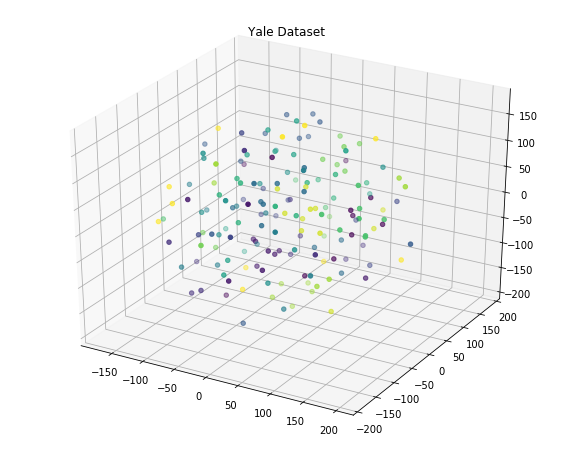

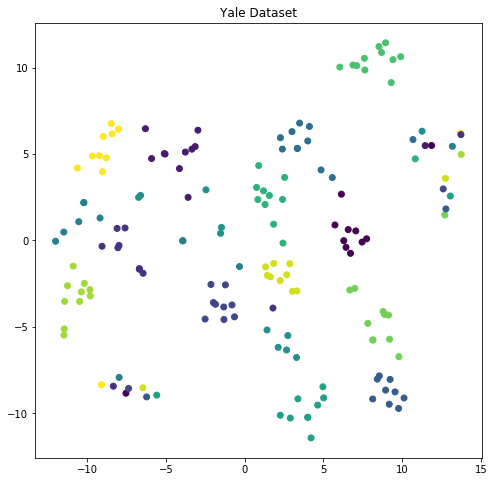

IIITCFW Dataset


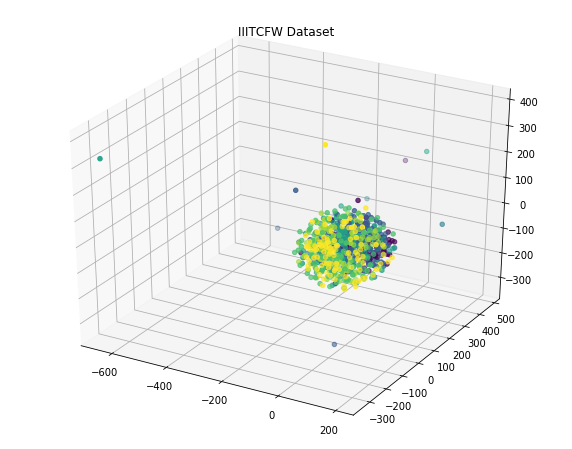

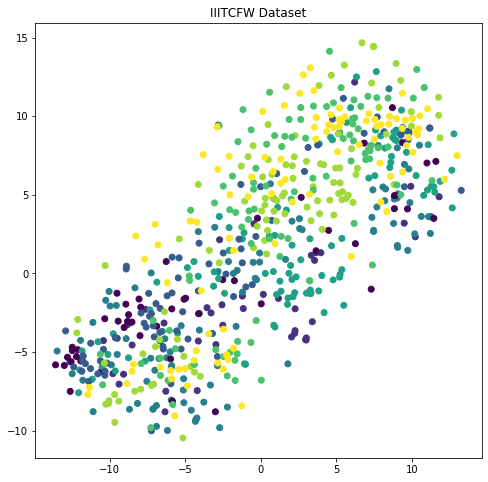

IMFDB Dataset


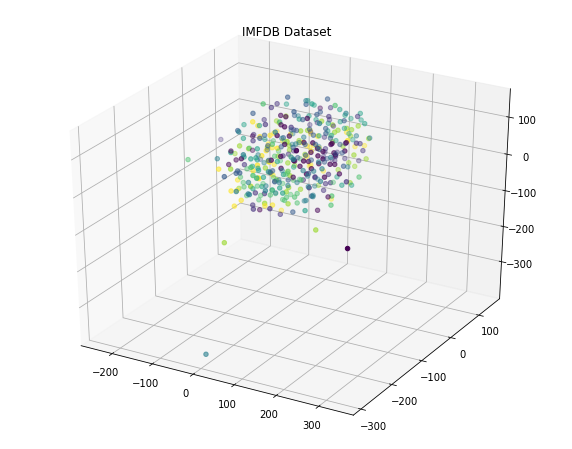

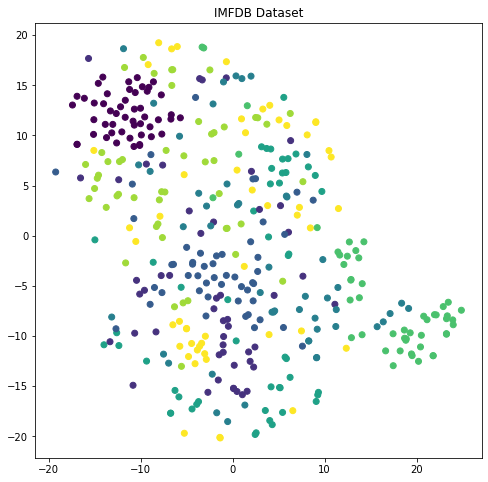

In [29]:
print("Yale Dataset")
Tsne_plots(Yale_data_flat,Yale_labels,"Yale Dataset")
print("IIITCFW Dataset")
Tsne_plots(IIITCFW_data_flat,IIITCFW_labels,"IIITCFW Dataset")
print("IMFDB Dataset")
Tsne_plots(IMFDB_data_flat,IMFDB_labels,"IMFDB Dataset")

(1237, 3072)


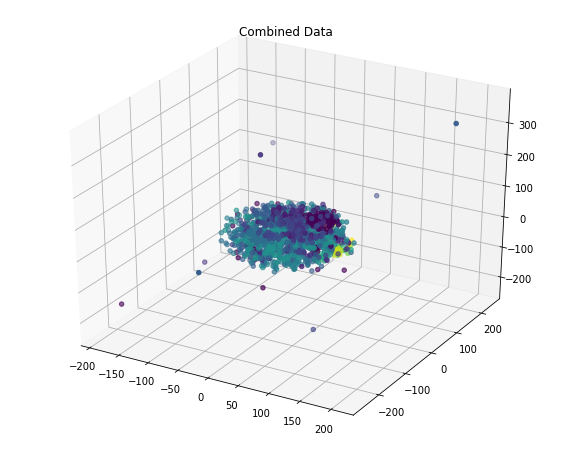

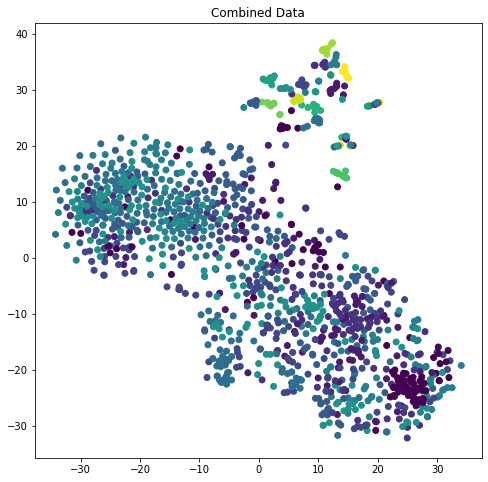

In [30]:
x = np.vstack((Yale_data_flat,IIITCFW_data_flat,IMFDB_data_flat))
y = np.hstack((Yale_labels,IIITCFW_labels,IMFDB_labels))
print(x.shape)
Tsne_plots(x,y,"Combined Data")

4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN 

4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

_______________________________________________________________________

4(c)Show empirical re-sults  with  all  the  representations

In [31]:
class FaceVerification():
    def __init__(self,k):
        self.k = k
    
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def verify(self,X,class_id):
        """
            Given an input X find if the class id is correct or not.
            
            @return verfication_results => N vector containing True or False. 
                    If the class-id matches with your prediction then true else false.   
        """
        verification_results = []
        for j in range(len(X)):
            errors = []
            for i in range(len(self.traindata)):
                errors.append((np.sqrt(np.mean((X[j] - self.traindata[i])**2)),self.trainlabels[i]))
            errors = sorted(errors,key=lambda x: x[0])
            errors = errors[0:k]
            votes = [0]*len(self.trainlabels)
            for m in errors:
                votes[m[1]] +=1
            final_vote = votes.index(max(votes))
            if(final_vote==class_id):
                verification_results.append(True)
            else:
                verification_results.append(False)
        return verfication_results
        
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your verification system will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.traindata = X_train
        self.trainlabels = y_train
        
    def validate(self,X_validate,y_validate):
        """
            How good is your system on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        preds = []
        for j in range(len(X_validate)):
            errors = []
            for i in range(len(self.traindata)):
                errors.append((np.sqrt(np.mean((X_validate[j] - self.traindata[i])**2)),self.trainlabels[i]))
            errors = sorted(errors,key=lambda x: x[0])
            errors = errors[0:self.k]
            votes = [0]*len(self.trainlabels)
            for m in errors:
                votes[m[1]] +=1
            final_vote = votes.index(max(votes))
            preds.append(final_vote)
        confmat = confusion_matrix(y_validate,preds)
        # Calculate Validation accuracy 
        accuracy = accuracy_score(y_validate,preds)
        # Calculate precision and recall 
        precision,recall,fscore,support = precision_recall_fscore_support(y_validate,preds,average="micro")
        # Calculate F1-score
    
        return confmat,accuracy,precision,recall,fscore,support

In [32]:
# Create a train and validation split and show your results 
Yale_train,Yale_test,Yale_train_labels,Yale_test_labels = train_test_split(Yale_data_flat,Yale_labels,test_size = 0.1)
IIITCFW_train,IIITCFW_test,IIITCFW_train_labels,IIITCFW_test_labels = train_test_split(IIITCFW_data_flat,IIITCFW_labels,test_size = 0.1)
IMFDB_train,IMFDB_test,IMFDB_train_labels,IMFDB_test_labels = train_test_split(IMFDB_data_flat,IMFDB_labels,test_size = 0.1)


In [33]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, verification error, accuracy, precision

# Print the table. (You can use Pandas)
def maketable4(traindata,trainlabels,testdata,testlabels,feature,k,datatype):
    if feature == "VGG":
        if(datatype == "Yale"):
            path = "./dataset/Yale_face_database/"
            VGGfeatures = get_vgg_features(path)
            traindata,testdata,trainlabels,testlabels = train_test_split(VGGfeatures,Yale_labels,test_size=0.1)
        elif(datatype == "IIITCFW"):
            path = "./dataset/IIIT-CFW/"
            VGGfeatures = get_vgg_features(path)
            traindata,testdata,trainlabels,testlabels = train_test_split(VGGfeatures,IIITCFW_labels,test_size=0.1)
        elif(datatype == "IMFDB"):
            path = "./dataset/IMFDB/"
            VGGfeatures = get_vgg_features(path)
            traindata,testdata,trainlabels,testlabels = train_test_split(VGGfeatures,IMFDB_labels,test_size=0.1)
    elif feature == "Resnet":
        if(datatype == "Yale"):
            path = "./dataset/Yale_face_database/"
            Resfeatures = get_resnet_features(path)
            traindata,testdata,trainlabels,testlabels = train_test_split(Resfeatures,Yale_labels,test_size=0.1)
        elif(datatype == "IIITCFW"):
            path = "./dataset/IIIT-CFW/"
            Resfeatures = get_resnet_features(path)
            traindata,testdata,trainlabels,testlabels = train_test_split(Resfeatures,IIITCFW_labels,test_size=0.1)
        elif(datatype == "IMFDB"):
            path = "./dataset/IMFDB/"
            Resfeatures = get_resnet_features(path)
            traindata,testdata,trainlabels,testlabels = train_test_split(Resfeatures,IMFDB_labels,test_size=0.1)
    elif feature == "PCA":
        traindata,comps = get_pca(traindata,75)
        testdata = comps.transform(testdata)
    elif feature == "KPCA":
        traindata,comps = get_kernel_pca(traindata,75)
        testdata = comps.transform(testdata)
    elif feature == "LDA":
        traindata,comps = get_lda(traindata,trainlabels,100)
        testdata = comps.transform(testdata)
    elif feature == "KLDA":
        traindata,comps = get_kernel_lda(traindata,trainlabels,100)
        testdata = comps.transform(testdata)
#     print("here",traindata.shape,trainlabels.shape)
    classifier = FaceVerification(k)
    classifier.train(traindata,trainlabels)
    confmat,accuracy,precision,recall,fscore,support = classifier.validate(testdata,testlabels)
    reduced = traindata.shape[1]
    out =  [confmat,accuracy,precision,recall,fscore,support,reduced]
    return out
def createtable4(traindata,testdata,trainlabels,testlabels,datatype):
    print(datatype)
#     print("check",traindata.shape,trainlabels.shape)
    store_accuracy = []
    store_confmat = []
    kvals = [3,5,7]
    features = ["PCA","KPCA","LDA","KLDA","VGG","Resnet"]
    dic = {"Feature Used":[],"Reduced Dimension Space":[],"Verification Error":[],"Accuracy":[],"Precision":[]}
    for i in features:
        for j in kvals:
            out = maketable4(traindata,trainlabels,testdata,testlabels,i,j,datatype)
            store_accuracy.append(out[1])
            store_confmat.append(out[0])
            dic["Feature Used"].append("Feature " + i + " and kvalue " + str(j))
            dic["Reduced Dimension Space"].append(out[6])
            dic["Verification Error"].append(1-out[1])
            dic["Accuracy"].append(out[1])
            dic["Precision"].append(out[2])
    dic = pd.DataFrame(dic)
#     dic = dic.sort_values(by=["Accuracy"],ascending=False)
    display(dic)
    print()  
    return store_accuracy,store_confmat

In [34]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
Yale_accs,Yale_confmats = createtable4(Yale_train,Yale_test,Yale_train_labels,Yale_test_labels,"Yale")
IIITCFW_accs,IIITCFW_confmats = createtable4(IIITCFW_train,IIITCFW_test,IIITCFW_train_labels,IIITCFW_test_labels,"IIITCFW")
IMFDB_accs,IMFDB_confmats = createtable4(IMFDB_train,IMFDB_test,IMFDB_train_labels,IMFDB_test_labels,"IMFDB")

Yale


,Feature Used,Reduced Dimension Space,Verification Error,Accuracy,Precision
0,Feature PCA and kvalue 3,75,0.235294,0.764706,0.764706
1,Feature PCA and kvalue 5,75,0.235294,0.764706,0.764706
2,Feature PCA and kvalue 7,75,0.235294,0.764706,0.764706
3,Feature KPCA and kvalue 3,75,0.235294,0.764706,0.764706
4,Feature KPCA and kvalue 5,75,0.235294,0.764706,0.764706
5,Feature KPCA and kvalue 7,75,0.235294,0.764706,0.764706
6,Feature LDA and kvalue 3,14,0.000000,1.000000,1.000000
7,Feature LDA and kvalue 5,14,0.000000,1.000000,1.000000
8,Feature LDA and kvalue 7,14,0.000000,1.000000,1.000000
9,Feature KLDA and kvalue 3,14,0.000000,1.000000,1.000000



IIITCFW


,Feature Used,Reduced Dimension Space,Verification Error,Accuracy,Precision
0,Feature PCA and kvalue 3,75,0.720588,0.279412,0.279412
1,Feature PCA and kvalue 5,75,0.661765,0.338235,0.338235
2,Feature PCA and kvalue 7,75,0.602941,0.397059,0.397059
3,Feature KPCA and kvalue 3,75,0.676471,0.323529,0.323529
4,Feature KPCA and kvalue 5,75,0.632353,0.367647,0.367647
5,Feature KPCA and kvalue 7,75,0.544118,0.455882,0.455882
6,Feature LDA and kvalue 3,7,0.647059,0.352941,0.352941
7,Feature LDA and kvalue 5,7,0.617647,0.382353,0.382353
8,Feature LDA and kvalue 7,7,0.647059,0.352941,0.352941
9,Feature KLDA and kvalue 3,7,0.647059,0.352941,0.352941



IMFDB


,Feature Used,Reduced Dimension Space,Verification Error,Accuracy,Precision
0,Feature PCA and kvalue 3,75,0.350,0.650,0.650
1,Feature PCA and kvalue 5,75,0.250,0.750,0.750
2,Feature PCA and kvalue 7,75,0.275,0.725,0.725
3,Feature KPCA and kvalue 3,75,0.375,0.625,0.625
4,Feature KPCA and kvalue 5,75,0.250,0.750,0.750
5,Feature KPCA and kvalue 7,75,0.275,0.725,0.725
6,Feature LDA and kvalue 3,7,0.325,0.675,0.675
7,Feature LDA and kvalue 5,7,0.300,0.700,0.700
8,Feature LDA and kvalue 7,7,0.350,0.650,0.650
9,Feature KLDA and kvalue 3,7,0.325,0.675,0.675


### Extenstion / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly avail-able or even create one by crawling from internet.

In [136]:
# Load data
X = np.vstack((Yale_data_flat,IMFDB_data_flat,IIITCFW_data_flat))
Y = np.hstack((np.ones(len(Yale_labels)),np.ones(len(IMFDB_labels)),np.zeros(len(IIITCFW_labels))))

Yale_res=get_resnet_features("./dataset/Yale_face_database/")
IMFDB_res=get_resnet_features("./dataset/IMFDB")
IIITCFW_res = get_resnet_features("./dataset/IIIT-CFW")

In [137]:
# Define your features
X_Resnet = np.vstack((Yale_res,IMFDB_res,IIITCFW_res))
s=np.arange(len(X_Resnet))
np.random.shuffle(s)
X_Resnet = X_Resnet[s]
Y = Y[s]

In [75]:
# Create your classifier
class Classifier5():
    def __init__(self,classifiertype,kernel,iters,degree=3,hidden_layer_sizes = (4000,)):
        if(classifiertype=="SVM"):
            self.classifier = SVC(C = 1,max_iter = iters,kernel = kernel,degree = degree)
        elif(classifiertype=="Logistic Regression"):
            self.classifier = LogisticRegression(random_state = 0,solver = 'lbfgs',multi_class = 'multinomial')
        elif(classifiertype=="MLP"):
            self.classifier = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes)
        elif(classifiertype == "KNN"):
            self.classifier = KNeighborsClassifier()
    
    
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def classify(self,X):
        """
            Given an input X classify it into appropriate class. 
        """
        prediction = self.classifier.predict(X)
        return prediction
        
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.classifier.fit(X_train,y_train)
        
    def validate(self,X_validate,y_validate):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        preds = self.classifier.predict(X_validate)
        
        
        # Create a confusion matrix
        # Calculate Validation accuracy 
        accuracy = accuracy_score(y_validate,preds)
        # Calculate precision and recall 
        return accuracy
# Validate your classifier

Mean Accuracy after K fold Validation for classifier  SVM  is  1.0
Mean Accuracy after K fold Validation for classifier  Logistic Regression  is  0.9975747745206359
Mean Accuracy after K fold Validation for classifier  MLP  is  1.0
Mean Accuracy after K fold Validation for classifier  KNN  is  1.0


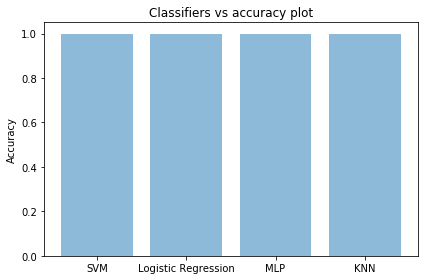

In [138]:
# Show qualitative results such as accuracy, k-fold validation, TSNE/PCA/Isomap plots, etc.
classifiers = ["SVM","Logistic Regression","MLP","KNN"]
res = []
wrong = []
kf = KFold(n_splits=3)
kf.get_n_splits(X_Resnet)
for i in classifiers:
    accs = []
    w = []
    classifier = Classifier5(i,"linear",1000,3,(60,10))
    for train_index, test_index in kf.split(X_Resnet):
        X_train, X_test = X_Resnet[train_index], X_Resnet[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        check_train,check_test = X[train_index], X[test_index]
        classifier.train(X_train,y_train)
        accs.append(classifier.validate(X_test,y_test))
        preds = classifier.classify(X_test)
        for j in range(len(preds)):
            if(preds[j]!=y_test[j]):
                w.append(check_test[j])
    wrong.append((w,i))
    accs = np.array(accs)
    res.append(np.mean(accs))
    print("Mean Accuracy after K fold Validation for classifier ",i," is ",np.mean(accs))     
y_pos = np.arange(len(classifiers))
plt.bar(y_pos,res, align='center', alpha=0.5)
plt.xticks(y_pos,classifiers)
plt.ylabel('Accuracy')
plt.title('Classifiers vs accuracy plot')
plt.tight_layout()
plt.show()   

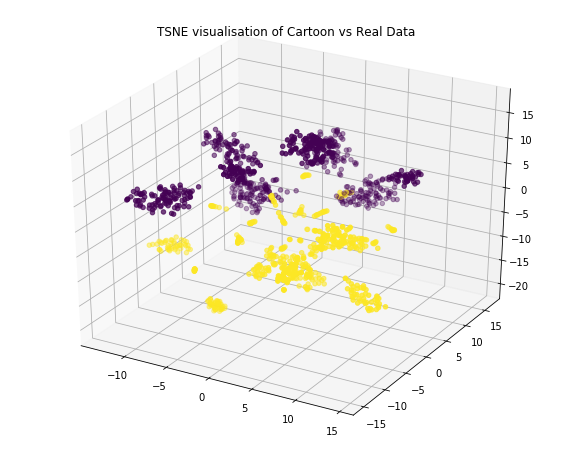

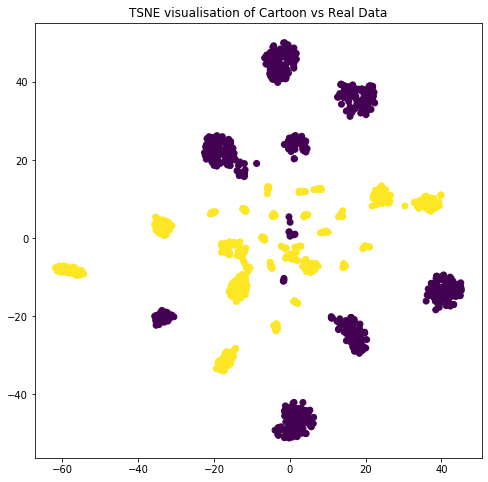

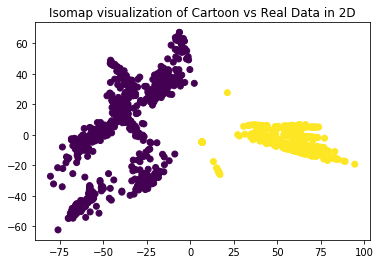

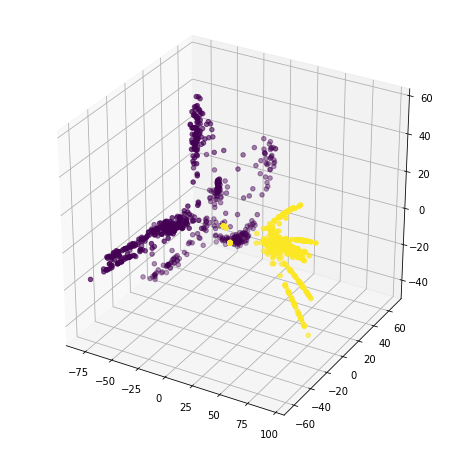

In [39]:
 #T-SNE
Tsne_plots(X_Resnet,Y,"TSNE visualisation of Cartoon vs Real Data")
#IsoMap
X_Iso = Isomap(n_components=2).fit_transform(X_Resnet)
plt.scatter(X_Iso[:,0],X_Iso[:,1],c=Y)
plt.title("Isomap visualization of Cartoon vs Real Data in 2D")
plt.show()
X_Iso = Isomap(n_components=3).fit_transform(X_Resnet)
fig = plt.figure(figsize=(8,8))
plt.title("Isomap visualization of Cartoon vs Real Data in 3D")
ax3 = fig.add_subplot(111, projection='3d')
ax3.scatter(X_Iso[:,0],X_Iso[:,1],X_Iso[:,2],c=Y)
plt.show()

For classifier  Logistic Regression  the misclassified photos are


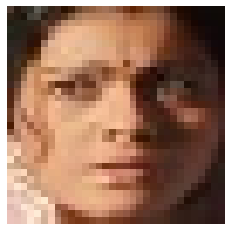

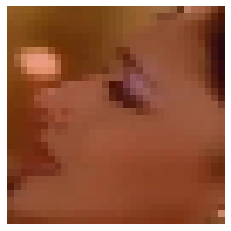

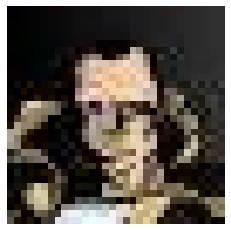

In [139]:
# Show quantitative results such as examples of correct prediction and wrong prediction
for i in wrong:
    if(len(i[0])>0):
        print("For classifier ",i[1]," the misclassified photos are")
        for j in i[0]:
            plt.imshow(j.reshape(32,32,3))
            plt.axis('off')
            plt.show()